# QOSF Task 1: Switching Rotation Gates
Pamela Pajarillo

We will be implementing the following 4 qubit state $|\psi(\theta) \rangle$
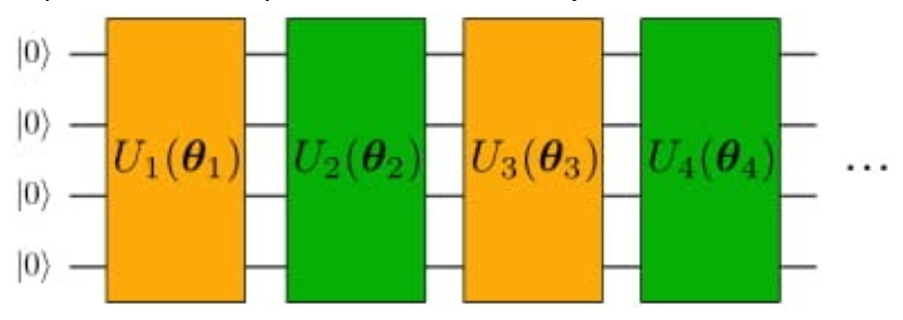
where the number of layers, denoted with L, is a parameter. We call "Layer" the combination of 1 yellow + 1 green block, so, for example, U1 + U2 is a layer. 

In [1]:
# installations
!pip install --upgrade qiskit 
!pip install pylatexenc

from IPython.display import clear_output
clear_output()

# import
import qiskit
import numpy as np
import random
import scipy
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.circuit.random import random_circuit
from numpy import linalg as LA
from timeit import default_timer as timer

pi = np.pi

We will be switching the Rotation Z gates to Rotation X gates for the green block implementation. (previous implementation found in QOSF_Task1)

In [2]:
# Implement Green Block - Even Block
def green_block(qcirc, rlist, index):
    
    '''
    Creates Green Block (Even) and appends to input circuit

    Inputs: 
      qcirc - input circuit
      rzlist - list of angles for the rotation z gates
      index - index of block to place green block
    '''
    
    # Throw error for an odd index
    if (index % 2 != 0):
          print("Error: Must be an even index to apply a green block")
          return
  
    # initialize quantum circuit
    qc = QuantumCircuit(qcirc.num_qubits)
  
    # add rotation blocks - rz
    for i in range(qcirc.num_qubits):
        # qc.rz(rlist[i], i)  # add rz gate with specified angle
        qc.rx(rlist[i], i)  # add rz gate with specified angle

    # add CZ gates
    for i in range(qcirc.num_qubits):
        for j in range(qcirc.num_qubits):
            if (j > i):
                qc.cx(i,j)   # add CZ gate

    # turn above gates to green block and append to qcirc
    qc = qc.to_gate()
    qc.name = "$R_z(theta_%d)$" % (index)
    qcirc.append(qc, range(qcirc.num_qubits))
    

We will be switching the Rotation X gates to Rotation Y gates for the yellow block implementation. (previous implementation found in QOSF_Task1)

In [3]:
# Implement Yellow Block - Odd
def yellow_block(qcirc, rlist, index):
  
    '''
    Creates Green Block (Even) and appends to input circuit

    Inputs: 
      qcirc - input circuit
      rzlist - list of angles for the rotation z gates
      index - index of block to place green block
    '''

    # Throw error for an even index
    if (index % 2 != 1):
          print("Error: Must be an odd index to apply a yellow block")
          return

    # initialize quantum circuit
    qc = QuantumCircuit(qcirc.num_qubits)

    # add rotation blocks - rx
    for i in range(qcirc.num_qubits):
        # qc.rx(rlist[i], i)  # add rz gate with specified angle
        qc.rz(rlist[i], i)  # add rz gate with specified angle

    # turn above gates to yellow block and append to qcirc
    qc = qc.to_gate()
    qc.name = "$R_x (theta_%d)$" % (index)
    qcirc.append(qc, range(qcirc.num_qubits))

The angles $\theta_{i,n}$ are variational parameters, lying in the interval $(0, 2\pi)$, which is initialized at random. The function *random_angle_parameters* outputs an array of random $\theta$s from 0 to $2\pi$ that will be used to initialize the circuit of layers of yellow and green blocks.

In [4]:
# Output a random angle from 0 to 2pi
def random_angle_parameters(num_qubits, num_layers):

    '''
    Creates Initial Angle Parameters Randomly

    Inputs:
      num_qubits - number of qubits
      num_layers - number of layers

    Returns:
      Output an array of random angles from 0 to 2pi based on inputs
    '''

    theta = []
    for i in range(num_qubits * num_layers * 2):
        theta.append(2 * pi * random.uniform(0,1))

    return theta

We will need to obtain the statevector of the circuit. By using one of Qiskit's simulations to view the state of the system, we can get the final statevector using *get_statevector* function.

In [5]:
# get statevector
def output_statevector(qc):

    '''
    Get statevector from the input circuit

    Inputs: 
      qcirc - input circuit
    
    Returns:
      Statevector for the given input circuit
    '''

    # Run the quantum circuit on a statevector simulator backend
    backend = Aer.get_backend('statevector_simulator')

    # Create a Quantum Program for execution
    job = execute(qc, backend)
    result = job.result()
    outputstate = result.get_statevector(qc)

    return outputstate

The function *initialize_circuit* takes in an array of angles, a quantum circuit, the number of layers, and the number of qubits specified and outputs the statevector of the system, along with the modifed circuit with the layers appended.

In [6]:
def initialize_circuit(angles, qc, num_layers, num_qubits):

    '''
    Initializes circuit with random angles initialized
    
    Parameters: 
      qc - input Quantum Circuit
      num_layers - number of layers
      num_qubits - number of qubits

    Returns:
      Modifies input qc with the number layers specified
      Outputs the statevector of the circuit
    '''

    # reshape array 
    theta = np.reshape(angles, (num_layers * 2, num_qubits))
    for i in range(num_layers):
        # Initialize random thetas
        yellow_theta = theta[(2*i)]
        green_theta = theta[(2*i)+1]
        # append yellow and green blocks
        yellow_block(qc, yellow_theta, (2*i)+1)  # odd index
        green_block(qc, green_theta, (2*i)+2)   # even index
    
    # compute return the statevector
    qc_vector = output_statevector(qc)

    return qc_vector

# Starting with One Layer
We will first start with one layer. We will create a random array of angles from 0 to $2\pi$ then initialize the circuit. We can see the amplitudes of each of the states possible for 4 qubits, shown when *qc_vector* is printed. The first element of the *qc_vector* array represents the amplitude of the $|0000\rangle$ state, the second element represents the amplitude of the $|0001\rangle$ state, etc., and the 16th element represents the amplitude of the $|1111\rangle$ state. The state of the layered circuit is denoted as $\psi(\theta)$.

[-1.74624475e-01+0.00000000e+00j  7.13217978e-02+1.74688023e-17j
  1.52169098e-17-8.28369989e-02j  9.20627396e-18-1.50349864e-01j
  2.66109992e-01+3.25890750e-17j -4.68021941e-02-5.73161572e-18j
 -3.32850447e-18+5.43586031e-02j -4.20882838e-17+2.29117946e-01j
  4.40601126e-18-7.19556245e-02j  3.17954341e-17-1.73086282e-01j
 -2.01031782e-01-2.46192928e-17j  6.19530472e-02+7.58706010e-18j
  3.95441645e-17-6.45805215e-01j  3.54264764e-18-1.92852755e-02j
 -2.23989635e-02-2.74308189e-18j  5.56031599e-01+6.80942318e-17j]


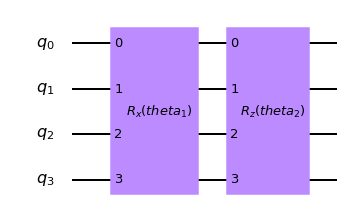

In [7]:
# Create new circuit
num_qubits = 4
num_layers = 1

# Create array of random angles
theta_list = random_angle_parameters(num_qubits, num_layers)

# Initialize circuit with layers using random angles
qc = QuantumCircuit(num_qubits)
qc_vector = initialize_circuit(theta_list, qc, num_layers, num_qubits)
qc_vector = output_statevector(qc)
print(qc_vector)
qc.draw('mpl')

Now we want to create a random state $\phi$, which will be fixed throughout the run. We can create a random circuit, using Qiskit's *random_circuit* and then obtain its statevector. The circuit of the random state is drawn below.


[ 0.3155487 -0.05337014j  0.00296201+0.08588435j  0.31121512+0.12243474j
  0.13135437+0.08915757j -0.10602331+0.1811614j  -0.01664159+0.05816758j
  0.24433421+0.06968392j -0.19879905-0.13467321j  0.4966355 -0.21339754j
 -0.06766645+0.11554671j -0.05486919-0.12303528j  0.06500499+0.13739861j
 -0.20634713-0.12832881j  0.01370941-0.14318689j  0.11371369+0.12759027j
 -0.33729801-0.09554297j]


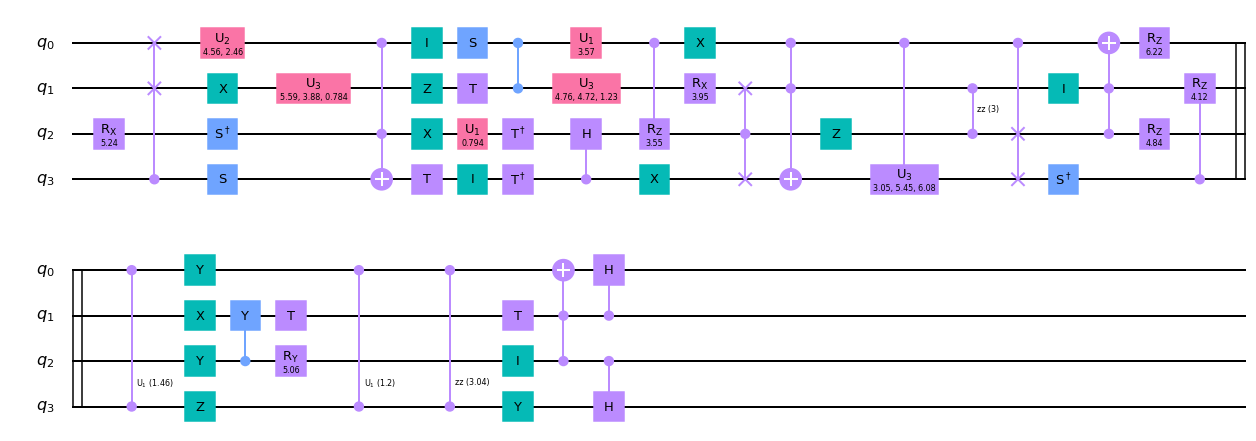

In [8]:
# Create random state
rand_circ = random_circuit(4, 20, measure=False)
rand_vector = output_statevector(rand_circ)
print(rand_vector)
rand_circ.draw('mpl')

We want to measure the difference between the two states. This can be done by using numpy's linear algebra function *norm*. We first subtract the amplitudes of the initial state prepared with random angles and the random state prepared using a random circuit. The distance is given as $$\epsilon = \text{min}_\theta || \, |\psi(\theta) \rangle - |\phi\rangle ||$$

In [9]:
initial_epsilon = LA.norm(np.subtract(qc_vector, rand_vector))

## Optimization of Angles
The correct set of the variational parameters $\theta_{i,n}$ need to found such that $\epsilon$ defined above is the minimum. We will be using *scipy.optimize.minimize*, a Scipy function that minimizes scalar functions of one or more variables. We first need to create an objective function to be minimized, in this case *optimize_angles*. The default method solver will be used, BFGS (quasi-Newton method of Broyden, Fletcher, Goldfarb, and Shanno), which uses first derivatives.

In [10]:
# Optimize Variational Parameters
def optimize_angles(angles):

    '''
    Function to optimize angles
 
    Parameters: 
      angles - array of angles
    
    Returns:
      Statevector for the given input circuit
    '''

    global rand_vector
    global num_qubits
    global num_layers

    qc = QuantumCircuit(num_qubits)
    qc_vector = initialize_circuit(angles, qc, num_layers, num_qubits)

    return LA.norm(np.subtract(qc_vector, rand_vector))

We will input the objective function *optimize_angles* and the initial angles into *scipy.optimize.minimize*. This will output an *OptimizeResult* object, which has several attributes, such as *x*, which is the the solution array, and *nfev*, which is the number of evaluations of the objective function. 

In [11]:
# Optimize variational parameters
final_optimized_angles = scipy.optimize.minimize(optimize_angles, theta_list)
print(final_optimized_angles)

      fun: 1.1041356152154627
 hess_inv: array([[  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   1.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   1.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         23.1807517 ,  -0.52455125,  13.50881326, -11.08567799],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         -0.52455125,  10.32702197,  -1.28604655,   2.32738306],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         13.50881326,  -1.28604655,  19.07885429,  -5.7001272 ],
       [  0.        ,   0.        ,   0.        ,   0.  

Now that we have the solution angles from the optimizer, we can set up the circuit with the optimized angles, and compare the $\epsilon$ between the initial random angles and the optimized angles given by the optimizer. 

In [12]:
# Extract angle from optimization
theta = np.array(final_optimized_angles.x)

# Set up circuit with optimized angles
final_qc = QuantumCircuit(num_qubits)
final_statevector = initialize_circuit(theta, final_qc, num_layers, num_qubits)
final_epsilon = LA.norm(np.subtract(final_statevector, rand_vector))

print("Initial Epsilon: " + str(initial_epsilon) + ", Final Epsilon: " + str(final_epsilon))

Initial Epsilon: 1.5665162962590253, Final Epsilon: 1.1041356152154627


# Increasing the Number of Layers
Now, we will iteratively increase the number of layers to see the effects on the minimum distance between $\psi(\theta)$ and $\phi$.

In [13]:
max_layers = 8
num_qubits = 4

optimized_epsilon = []
initial_epsilon = []
times = []
num_fev = []

for i in range(1,max_layers):
    # Create new circuit
    num_layers = i
    qc = QuantumCircuit(num_qubits)
    theta_list = random_angle_parameters(num_qubits, num_layers)
    qc_vector = initialize_circuit(theta_list, qc, num_layers, num_qubits)

    # time the process of the optimization
    start = timer()
    # optimize the thetas (variational parameters)
    final_optimized_angles = scipy.optimize.minimize(optimize_angles, theta_list)
    end = timer()
    time_taken = end - start
    print("Number of Layers: " + str(i) + ", Time Taken: " + str(time_taken))

    # print(final_optimized_angles)

    # Extract the solution of theta from optimization
    theta = np.array(final_optimized_angles.x)

    # Set up circuit with optimized angles
    final_qc = QuantumCircuit(num_qubits)
    final_statevector = initialize_circuit(theta, final_qc, num_layers, num_qubits)

    # Calculate epsilon after optimization
    final_epsilon = LA.norm(np.subtract(final_statevector, rand_vector))
    
    # Save additional variables to to printed in plots
    initial_epsilon.append(LA.norm(np.subtract(qc_vector, rand_vector)))
    optimized_epsilon.append(final_epsilon)
    num_fev.append(final_optimized_angles.nfev)
    times.append(time_taken)

Number of Layers: 1, Time Taken: 5.106738250999996
Number of Layers: 2, Time Taken: 16.815667085
Number of Layers: 3, Time Taken: 39.764421698999996
Number of Layers: 4, Time Taken: 168.43986264200004
Number of Layers: 5, Time Taken: 399.78162879300004
Number of Layers: 6, Time Taken: 440.07049219099997
Number of Layers: 7, Time Taken: 494.796713684


# Results

In [14]:
# Print out arrays
print("Initial epsilon: " + str(initial_epsilon))
print("Optimized epsilon: " + str(optimized_epsilon))
print("Number of function Evaluations: " + str(num_fev))

Initial epsilon: [1.4258002124473674, 1.2648101708546076, 1.3661888259311927, 1.5348223485194699, 1.5391798408388422, 1.3831171987874287, 1.2013942704054956]
Optimized epsilon: [1.1041356151449497, 0.5556345840867547, 0.3286072023362954, 0.030315974808402774, 1.536789107031715e-06, 1.962498736443582e-06, 2.6717844880400473e-06]
Number of function Evaluations: [280, 684, 1274, 4454, 8790, 8612, 8711]


We can now see the effects of the additional layers on the minimum distance between $\psi(\theta)$ and $\phi$.

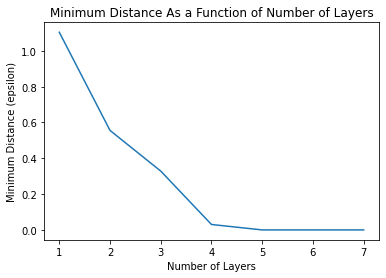

In [15]:
fig, ax1 = plt.subplots()

ax1.plot(range(1,max_layers), optimized_epsilon)
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Minimum Distance (epsilon)')
ax1.set_title('Minimum Distance As a Function of Number of Layers')
fig.show()

We can see the more layers added, the mininum distance between $\psi(\theta)$ and the random state $\phi$ generated decreases as the number of layers increases and the distance is close to zero after 4 layers. This is because there are so many parameters to tune that it's likely for $\psi(\theta)$ and $\phi$ to be similar. The plot below shows the $\epsilon$ before and after optimization.

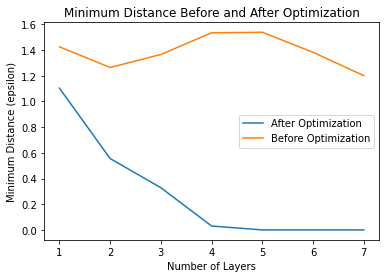

In [16]:
fig, ax1 = plt.subplots()

ax1.plot(range(1,max_layers), optimized_epsilon, label = "After Optimization")
ax1.plot(range(1,max_layers), initial_epsilon, label = "Before Optimization")
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Minimum Distance (epsilon)')
ax1.set_title('Minimum Distance Before and After Optimization')
ax1.legend()
fig.show()

We can then plot the difference of $\epsilon$ before and after optimization of angles. 

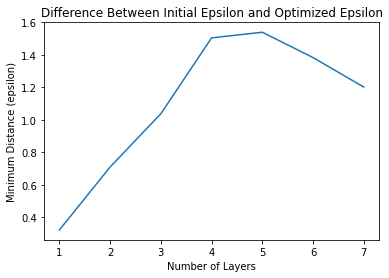

In [17]:
fig, ax1 = plt.subplots()

diff_epsilon = np.subtract(initial_epsilon, optimized_epsilon)
ax1.plot(range(1,max_layers), diff_epsilon)
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Minimum Distance (epsilon)')
ax1.set_title('Difference Between Initial Epsilon and Optimized Epsilon')
fig.show()

The number of times *optimize_angles* was called during optimization is plotted below. As the number of layers increase, the number of the function *optimize_angles* evaluations increases. 

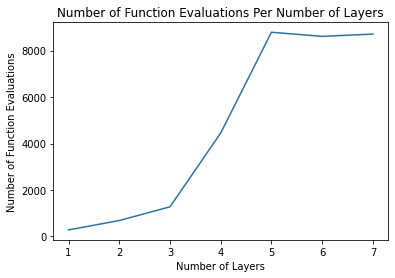

In [18]:
fig, ax1 = plt.subplots()

ax1.plot(range(1,max_layers), num_fev)
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Number of Function Evaluations')
ax1.set_title('Number of Function Evaluations Per Number of Layers')
fig.show()

Additionally, we can analyze the runtime for the number of layers specified. As the number of layers increase, the time it takes to optimize increases.

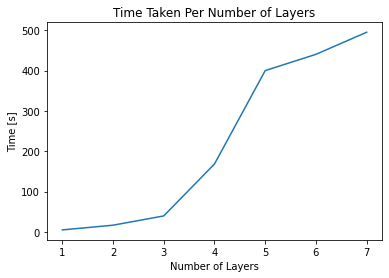

In [19]:
fig, ax1 = plt.subplots()

ax1.plot(range(1,max_layers), times)
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Time [s]')
ax1.set_title('Time Taken Per Number of Layers')
fig.show()

# Conclusion
We implemented the 4-qubit state, which depends on layers of one yellow and one green block. These blocks depend on variational parameters, $\theta_{i,n}$, which lie in the interval $(0,2\pi)$. These variational parameters are initialized at random, which then need to be optimized to give the minimum distance $\epsilon$. *Scipy.optimize.minimize* is used to give the correct $\theta_{i,n}$. The number of layers are then varied to see the effects of $\epsilon$. We concluded that the more layers added, the mininum distance between $\psi(\theta)$ and the random state $\phi$ generated by Qiskit's *random_circuit* function decreases as the number of layers increases and the distance is close to zero after four layers.